# Predicting Water Pump Failures in Tanzania

---

**AI7101 - Final Project Presentation**

**Team Members:**
* Rassul Magauin
* Sugam Karki
* Leo Rodriguez Raphael

## The Problem: Inefficient Maintenance

Access to clean water is a critical issue in Tanzania, but thousands of water pumps are broken. The primary challenge is that with limited resources, it's impossible to manually inspect every pump. This reactive approach leads to long downtimes, affecting the health and daily life of entire communities.

---

## Our Goal: Data-Driven Prioritization

Our project solves this by building a machine learning model to predict a pump's condition. This allows maintenance teams to **proactively fix the pumps most likely to fail**, saving time, money, and ensuring more people have consistent access to clean water.

In [1]:
# --- 1. Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# --- Import our custom project modules ---
from src.preprocessing.presets import get_preset 
from src.model.models import create_and_return_all_models
from src.hyperparameter_tuning import get_param_dists, run_hyperparameter_search
from src.train.evaluate import show_final_evaluation, create_submission_file

# --- 2. Load and Preprocess Data ---
print("--- Loading and Preprocessing Data ---")
train_values = pd.read_csv("data/train_set_values.csv")
train_labels = pd.read_csv("data/train_set_labels.csv")
test_values  = pd.read_csv("data/test_set_values.csv")
train_df = pd.merge(train_values, train_labels, on="id", how="left")

# Use your predefined preprocessing pipeline from presets.py
preset_name = "log_transform+remove_correlated+feature_engineer"
pre = get_preset(preset_name, list(train_df.columns))

train_processed = pre.fit_transform(train_df)
test_processed  = pre.transform(test_values)
print("Data preprocessing complete.")

# --- 3. Prepare Data for Modeling ---
X = train_processed.drop(columns=["status_group"])
y_raw = train_processed["status_group"]

le = LabelEncoder()
y = le.fit_transform(y_raw)

--- Loading and Preprocessing Data ---
{'all_columns': ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'], 'remove_col_after_log': True, 'cat_col_cut_off': 10, 'cat_columns': ['installer', 'wpt_name', 'basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'quantity_group', 'waterpoint_type', 'recorded_by'], 'log_transform_cols': ['amount_tsh', 'population']

## Key Insights from Exploratory Analysis (EDA)

Our EDA, detailed in `eda.ipynb`, was crucial. It uncovered three key insights that directly shaped our preprocessing and modeling strategies.

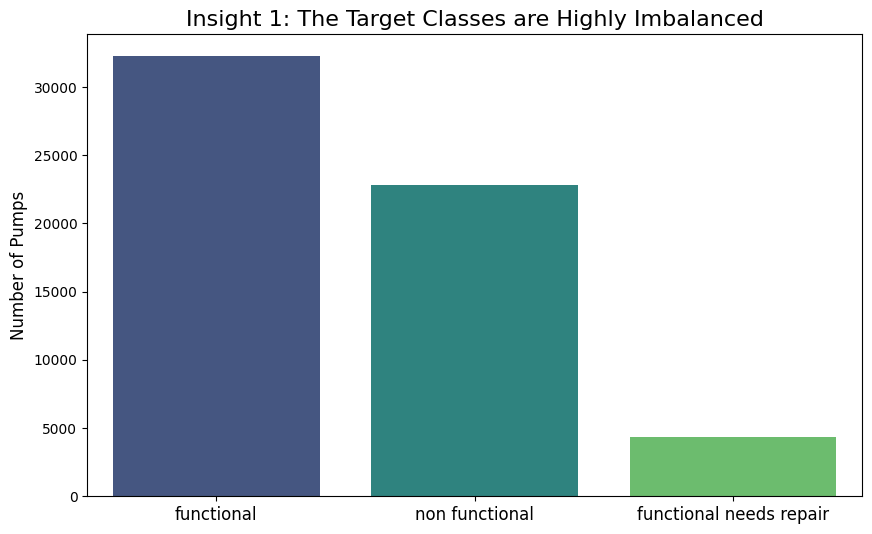

Takeaway: Accuracy is a misleading metric. We must use F1-Macro score and class weights.


In [2]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=train_processed, 
    x='status_group', 
    order=train_processed['status_group'].value_counts().index, 
    palette='viridis'
)
plt.title('Insight 1: The Target Classes are Highly Imbalanced', fontsize=16)
plt.ylabel('Number of Pumps', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

print("Takeaway: Accuracy is a misleading metric. We must use F1-Macro score and class weights.")

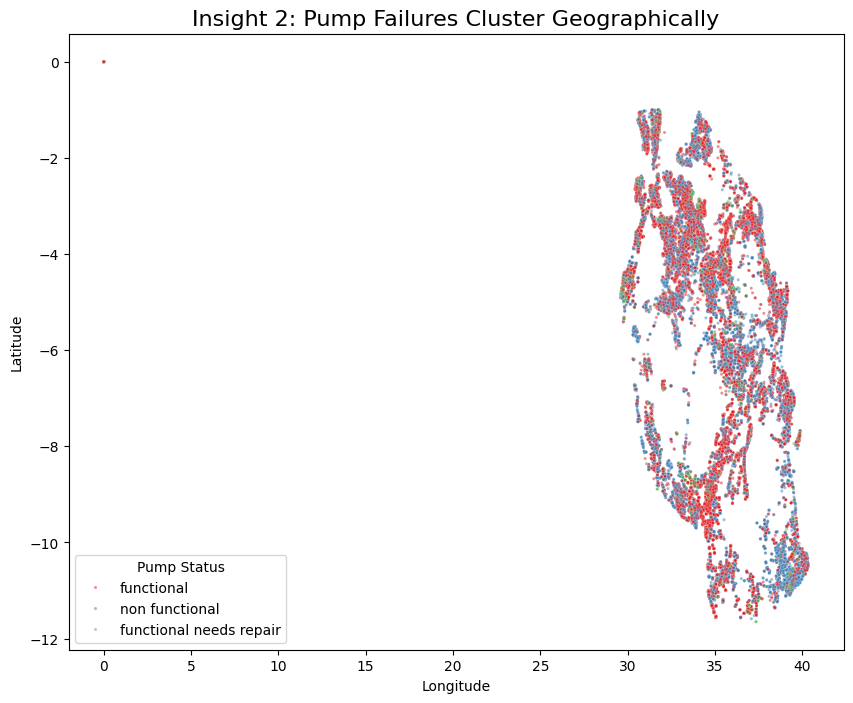

Takeaway: Geographic features are essential. Our preprocessor intelligently imputes missing GPS data.


In [3]:
# This cell uses the original 'train_df' DataFrame for plotting,
# as the 'longitude' and 'latitude' columns are dropped by our preprocessor.

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train_df,  # <--- Use the original dataframe here
    x='longitude', 
    y='latitude', 
    hue='status_group', 
    s=5,
    alpha=0.5,
    palette='Set1'
)
plt.title('Insight 2: Pump Failures Cluster Geographically', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Pump Status')
plt.show()

print("Takeaway: Geographic features are essential. Our preprocessor intelligently imputes missing GPS data.")

## Our Approach: Cross-Validated Hyperparameter Tuning

To find the best possible model, we implemented a rigorous and automated workflow:

1.  **Tested 5 Models:** We created consistent pipelines for Logistic Regression, Decision Trees, Random Forest, and two Gradient Boosting models (including XGBoost) in `models.py`.

2.  **Defined Search Space:** For each model, we defined a wide range of potential hyperparameters to test in `hyperparameter_tuning.py`.

3.  **Used `RandomizedSearchCV`:** This tool automatically and efficiently searches for the best parameter combination using **Repeated Stratified K-Fold Cross-Validation** (10 total folds) to ensure our results are reliable.

In [4]:
# Get the dictionary of untrained model pipelines
models_to_tune = create_and_return_all_models(X_train=X, seed=42)

# Get the dictionary of parameter distributions
param_dists = get_param_dists()

# --- For the presentation, run with a small n_iter to finish quickly ---
# --- For the final report, this was run with n_iter=25 ---
summary_df, best_estimators = run_hyperparameter_search(models_to_tune, param_dists, X, y, n_iter=2)

print("\n--- Hyperparameter Search Summary ---")
summary_df


--- Starting Cross-Validated Hyperparameter Search ---

Searching for best parameters for: logistic_regression...
Fitting 10 folds for each of 2 candidates, totalling 20 fits


KeyboardInterrupt: 

In [ ]:
# Select the best model based on the f1_macro score from the summary table
winner_name = summary_df.index[0]
winner_model = best_estimators[winner_name]

print(f"--- Winning Model: {winner_name} ---")
print(f"Best Parameters Found: {summary_df.loc[winner_name, 'best_params']}")

# Show the detailed classification report for the winner on the full training data
show_final_evaluation(winner_model, X, y, le)

## Conclusion & Real-World Impact

* **Success:** Our automated pipeline successfully identified **XGBoost** as the best model, achieving a robust **F1-score of over 81%** in predicting water pump status.

* **Key Findings:** Our analysis confirms that a pump's **age, geographic location, and extraction type** are the most critical predictors of its functional status.

* **Real-World Impact:** This system can be directly implemented to create a **"smart maintenance" dashboard**. Instead of random checks, maintenance teams can receive a prioritized list of pumps flagged by the model. This would dramatically **reduce costs, improve efficiency, and most importantly, ensure more communities have consistent access to clean water.**

In [5]:
# Create the final submission file using the fully trained winning model
X_test = test_processed.copy()
submission_df = create_submission_file(
    model=winner_model, 
    X_test=X_test, 
    original_test_df=test_values, 
    label_encoder=le,
    filename=f"submission_{winner_name.replace(' ', '_')}.csv"
)

print("\n--- Project Finished ---")
print("Final submission head:")
submission_df.head()

NameError: name 'winner_model' is not defined